In [1]:
#Подключаем библиотеки
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPooling2D, MaxPooling1D
from keras.utils import plot_model
from google.colab import files
from keras.utils import to_categorical
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
%matplotlib inline

from keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# Указываем путь к базе
data_path = '/content/drive/My Drive/datasets/data/'
!ls drive/MyDrive/datasets/data/bed/

00176480_nohash_0.wav  5e3dde6b_nohash_0.wav  b087aa0e_nohash_0.wav
004ae714_nohash_0.wav  5efb758c_nohash_0.wav  b0bad4a9_nohash_0.wav
004ae714_nohash_1.wav  5f1b1051_nohash_0.wav  b0c0197e_nohash_0.wav
00f0204f_nohash_0.wav  5f47fdf9_nohash_0.wav  b0c0197e_nohash_1.wav
00f0204f_nohash_1.wav  5f8e50a0_nohash_0.wav  b0f24c9b_nohash_0.wav
012c8314_nohash_0.wav  5f8e50a0_nohash_1.wav  b0f24c9b_nohash_1.wav
012c8314_nohash_1.wav  5fadb538_nohash_0.wav  b1114e4f_nohash_0.wav
0132a06d_nohash_0.wav  5fb88f4c_nohash_0.wav  b12bef84_nohash_0.wav
0135f3f2_nohash_0.wav  5ff3f9a1_nohash_0.wav  b12bef84_nohash_1.wav
0137b3f4_nohash_0.wav  6021f08b_nohash_0.wav  b12bef84_nohash_2.wav
014f9f65_nohash_0.wav  6021f08b_nohash_1.wav  b1426003_nohash_0.wav
01648c51_nohash_0.wav  60472d26_nohash_0.wav  b15fc37d_nohash_0.wav
01648c51_nohash_1.wav  60472d26_nohash_1.wav  b16f2d0d_nohash_0.wav
016e2c6d_nohash_0.wav  60472d26_nohash_2.wav  b1df80c0_nohash_0.wav
01b4757a_nohash_0.wav  605ed0ff_nohash_0.wav  b1

In [7]:
# Функция для загрузки данных
def get_labels(path=data_path):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=16000)
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]   
    return mfcc
    

In [8]:
# Сохраняем данные в массив
def save_data_to_array(path=data_path, max_len=11):
    labels, _, _ = get_labels(path)
    for label in labels:
        mfcc_vectors = []
        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)

# Функция получения выборки
def get_train_test(split_ratio=0.6, random_state=42):
    labels, indices, _ = get_labels(data_path)
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
    assert X.shape[0] == len(y)
    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

# Функция подготовки данных
def prepare_dataset(path=data_path):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path  + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        vectors = []
        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(wave, sr=16000)
            vectors.append(mfcc)
        data[label]['mfcc'] = vectors
    return data

# Загружаем датасет
def load_dataset(path=data_path):
    data = prepare_dataset(path)
    dataset = []
    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))
    return dataset[:100]


In [9]:
feature_dim_2 = 11
save_data_to_array(max_len=feature_dim_2)
# Загружаем данные
X_train, X_test, y_train, y_test = get_train_test()

Saving vectors of label - 'happy': 100%|██████████| 1742/1742 [10:55<00:00,  2.66it/s]


In [10]:
feature_dim_1 = 20
channel = 1
num_classes = 3

# Подготавливаем X_train
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

# Подготавливаем Y_train
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

[1. 0. 0.]


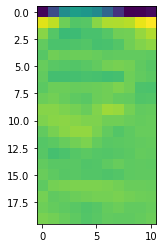

In [40]:
plt.imshow(X_train[100, :, :, 0])
print(y_train_hot[100])

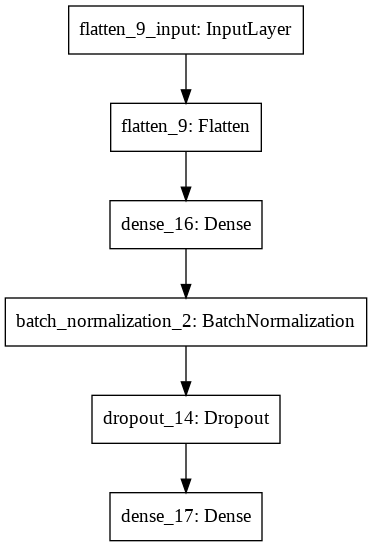

In [68]:
# Создаём сеть
model = Sequential()
model.add(Flatten(input_shape=(feature_dim_1, feature_dim_2)))
model.add(Dense(64, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
                  
plot_model(model, to_file='model.png')

Epoch 1/150
32/32 [==============================] - 0s 8ms/step - loss: 1.6803 - accuracy: 0.3644 - val_loss: 1.3649 - val_accuracy: 0.3439
Epoch 2/150
32/32 [==============================] - 0s 3ms/step - loss: 1.3060 - accuracy: 0.4354 - val_loss: 1.1193 - val_accuracy: 0.4104
Epoch 3/150
32/32 [==============================] - 0s 3ms/step - loss: 1.1824 - accuracy: 0.4843 - val_loss: 1.0309 - val_accuracy: 0.4432
Epoch 4/150
32/32 [==============================] - 0s 3ms/step - loss: 1.0317 - accuracy: 0.5392 - val_loss: 0.9663 - val_accuracy: 0.4947
Epoch 5/150
32/32 [==============================] - 0s 3ms/step - loss: 0.9426 - accuracy: 0.5871 - val_loss: 0.8747 - val_accuracy: 0.5862
Epoch 6/150
32/32 [==============================] - 0s 3ms/step - loss: 0.8817 - accuracy: 0.6051 - val_loss: 0.7818 - val_accuracy: 0.6758
Epoch 7/150
32/32 [==============================] - 0s 3ms/step - loss: 0.8196 - accuracy: 0.6362 - val_loss: 0.7334 - val_accuracy: 0.6946
Epoch 8/150
3

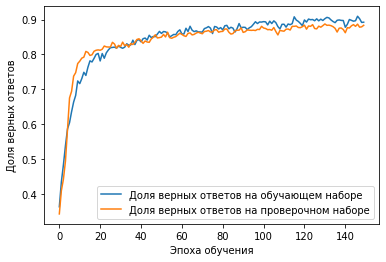

In [69]:
# Обучаем модель
history = model.fit(X_train, y_train_hot, batch_size=100, epochs=150, verbose=1, validation_data=(X_test, y_test_hot))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [70]:
# Функция прогнозирования
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][np.argmax(model.predict(sample_reshaped))]
            

In [75]:
# Результат модели
print(predict('/content/drive/My Drive/datasets/data/bed/52e228e9_nohash_0.wav', model=model))

bed
